In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install Scikit-Video

In [5]:
!pip install scikit-video

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.2 MB/s eta 0:00:00


## Import libraries

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import skvideo.io
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import io
import imageio
import ipywidgets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K


## Load, resize and trim the videos

In [7]:
def frame_crop_center(video,cropf):
    f,_,_,_ = video.shape
    startf = f//2 - cropf//2
    return video[startf:startf+cropf, :, :, :]

fights=[]
nofights=[]

surv_fights=[]
surv_no_fights=[]

video_dims = []

####### Fight data
for filename in os.listdir('/content/drive/MyDrive/Peliculas/fights'):
    f = os.path.join('/content/drive/MyDrive/Peliculas/fights', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)
    L=[]

    #resize video dimensions
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)

    #center crop video to have consistent video frame number
    video = frame_crop_center(video, 42)

    fights.append(video)

for filename in os.listdir('/content/drive/MyDrive/Peliculas/fights'):
    f = os.path.join('/content/drive/MyDrive/Peliculas/fights', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    surv_fights.append(video)

####### Non Fight data
for filename in os.listdir('/content/drive/MyDrive/Peliculas/noFights'):
    f = os.path.join('/content/drive/MyDrive/Peliculas/noFights', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    nofights.append(video)

for filename in os.listdir('/content/drive/MyDrive/Peliculas/noFights'):
    f = os.path.join('/content/drive/MyDrive/Peliculas/noFights', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    surv_no_fights.append(video)

## Video duration and dimension analysis

In [8]:
data= pd.DataFrame(video_dims, columns=['frame_length', 'height', 'width', 'channels'])
data.describe()

,frame_length,height,width,channels
count,402.000000,402.000000,402.0,402.0
mean,48.960199,514.865672,720.0,3.0
std,5.131528,46.225587,0.0,0.0
min,42.000000,480.000000,720.0,3.0
25%,42.000000,480.000000,720.0,3.0
50%,50.000000,480.000000,720.0,3.0
75%,50.000000,576.000000,720.0,3.0
max,60.000000,576.000000,720.0,3.0


## Aggregate data and create labels

In [9]:
surv_fights = [video for video in surv_fights if video.shape[0] == 42]
surv_no_fights = [video for video in surv_no_fights if video.shape[0] == 42]

videos = fights + surv_fights + nofights + surv_no_fights
videos = np.asarray(videos)

labels = np.concatenate([np.ones(len(fights)+len(surv_fights)) , np.zeros(len(nofights)+len(surv_no_fights))])

del fights
del nofights
del surv_fights
del surv_no_fights

## Train, test, val split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=2334)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=124567)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(288, 42, 128, 128, 3)
(33, 42, 128, 128, 3)
(81, 42, 128, 128, 3)


## Set ViVit model hyperparameters

In [11]:
# Setting seed for reproducibility
SEED = 77
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
tf.random.set_seed(SEED)

# DATA
DATASET_NAME = "fight/nofights"
BATCH_SIZE = 4
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (42, 128, 128, 3)
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 20

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 64
NUM_HEADS = 2
NUM_LAYERS = 2

## Preprocess and prepare dataloader

Takes around 5 ~ 10 minutes to execute

In [12]:
@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels"""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )

    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare dataloader"""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataloader


trainloader = prepare_dataloader(X_train, y_train, "train")
validloader = prepare_dataloader(X_val, y_val, "valid")
testloader = prepare_dataloader(X_test, y_test, "test")

## Define some model classes

In [13]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

## Create model

In [14]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Define metrics, build, train and save ViVit model

In [15]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            recall_m,
            precision_m,
            f1_m,
        ],
    )

    # Train the model.
    _ = model.fit(trainloader, epochs=EPOCHS, validation_data=validloader)

    _, accuracy, recall, precision, f1 = model.evaluate(testloader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test recall: {round(recall * 100, 2)}%")
    print(f"Test precision: {round(precision * 100, 2)}%")
    print(f"Test F1: {round(f1 * 100, 2)}%")

    vivit_scores = [accuracy, recall, precision, f1]
    return model, vivit_scores


model, vivit_scores = run_experiment()

model.save('vivit_model')


Epoch 1/20
72/72 [==============================] - 93s 1s/step - loss: 0.5454 - accuracy: 0.7431 - recall_m: 0.9167 - precision_m: 0.4896 - f1_m: 0.6160 - val_loss: 0.3752 - val_accuracy: 0.8182 - val_recall_m: 0.8889 - val_precision_m: 0.4444 - val_f1_m: 0.5757
Epoch 2/20
72/72 [==============================] - 85s 1s/step - loss: 0.3591 - accuracy: 0.8368 - recall_m: 0.9306 - precision_m: 0.4896 - f1_m: 0.6157 - val_loss: 0.2327 - val_accuracy: 0.8182 - val_recall_m: 0.8889 - val_precision_m: 0.4444 - val_f1_m: 0.5757
Epoch 3/20
72/72 [==============================] - 85s 1s/step - loss: 0.1104 - accuracy: 0.9549 - recall_m: 0.9306 - precision_m: 0.4896 - f1_m: 0.6119 - val_loss: 0.0133 - val_accuracy: 1.0000 - val_recall_m: 0.8889 - val_precision_m: 0.4444 - val_f1_m: 0.5757
Epoch 4/20
72/72 [==============================] - 83s 1s/step - loss: 0.0404 - accuracy: 0.9931 - recall_m: 0.9444 - precision_m: 0.4896 - f1_m: 0.6180 - val_loss: 0.0077 - val_accuracy: 1.0000 - val_recall

### Plot Confusion Matrix

21/21 [==============================] - 9s 429ms/step


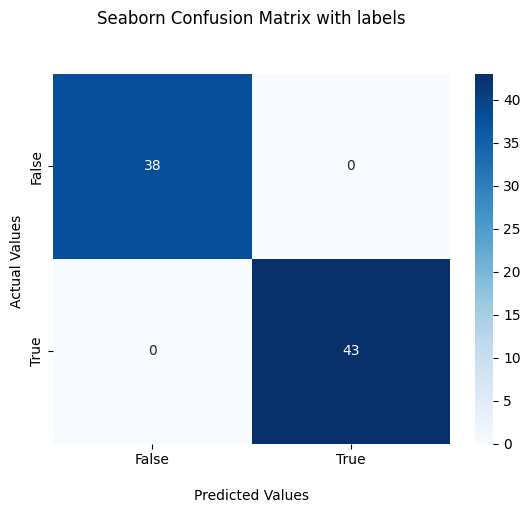

In [16]:
y_preds = np.argmax(model.predict(testloader), axis=1)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_preds)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
ax.figure.savefig("vivit_cf.png")


### Visualise predictions

In [17]:
NUM_SAMPLES_VIZ = 25

testsamples, labels_ = next(iter(testloader))
testsamples, labels_ = X_test[:NUM_SAMPLES_VIZ], y_test[:NUM_SAMPLES_VIZ]

ground_truths = []
preds = []
videos_ = []

for i, (testsample, label) in enumerate(zip(testsamples, labels_)):
    # Generate gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, (testsample * 255).astype("uint8"), "GIF", fps=5)
        videos_.append(gif.getvalue())

    # Get model prediction
    output = model.predict(tf.expand_dims(testsample, axis=0))[0]
    pred = np.argmax(output, axis=0)

    ground_truths.append(label.astype("int"))
    preds.append(pred)


def make_box_for_grid(image_widget, fit):
    """Make a VBox to hold caption/image for demonstrating option_fit values.

    Source: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
    """
    # Make the caption
    if fit is not None:
        fit_str = "'{}'".format(fit)
    else:
        fit_str = str(fit)

    h = ipywidgets.HTML(value="" + str(fit_str) + "")

    # Make the green box with the image widget inside it
    boxb = ipywidgets.widgets.Box()
    boxb.children = [image_widget]

    # Compose into a vertical box
    vb = ipywidgets.widgets.VBox()
    vb.layout.align_items = "center"
    vb.children = [h, boxb]
    return vb


boxes = []
label_dict = {0: 'noFight', 1: 'Fight'}
for i in range(NUM_SAMPLES_VIZ):
    ib = ipywidgets.widgets.Image(value=videos_[i], width=200, height=200)
    true_class = label_dict[ground_truths[i]]
    pred_class = label_dict[preds[i]]
    caption = f"T: {true_class} | P: {pred_class}"

    boxes.append(make_box_for_grid(ib, caption))

ipywidgets.widgets.GridBox(
    boxes, layout=ipywidgets.widgets.Layout(grid_template_columns="repeat(5, 200px)")
)

1/1 [==============================] - 0s 98ms/step


GridBox(children=(VBox(children=(HTML(value="'T: Fight | P: noFight'"), Box(children=(Image(value=b'GIF89a\x80…

# *CNN-RNN model*

### Build Inception V3 feature extractor

In [18]:
IMG_SIZE = 128

def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 0s 0us/step


### Create masks, process and prepare data

Takes around 10 ~ 20 minutes to execute

In [19]:
MAX_SEQ_LENGTH = 42
NUM_FEATURES = 2048

def prepare_all_videos():
    num_samples = len(videos)


    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    for idx in range(len(videos)):
        if idx % 25 == 0:
            print(idx,'/',len(videos), ' videos prepared')
        frames = videos[idx][None, ...]

        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks)


processed_data = prepare_all_videos()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 61ms/step
300 / 402  videos prepared
1/1 [==============================] - 0s 63ms/step
325 / 402  videos prepared
1/1 [==============================] - 0s 131ms/step
350 / 402  videos prepared
1/1 [==============================] - 0s 61ms/step
375 / 402  videos prepared
1/1 [==============================] - 0s 63ms/step
400 / 402  videos prepared
1/1 [==============================] - 0s 56ms/step


In [20]:
processed_data[0].shape

(402, 42, 2048)

### Train, test split

In [21]:
X_train_features, X_test_features, y_train, y_test = train_test_split(processed_data[0], labels, test_size=0.2, random_state=2334)
X_train_masks, X_test_masks, y_train, y_test = train_test_split(processed_data[1], labels, test_size=0.2, random_state=2334)


print(X_train_features.shape)
print(X_test_features.shape)

(321, 42, 2048)
(81, 42, 2048)


### Build train and evaluate model

In [22]:
def get_sequence_model():
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")


    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(2, activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy", recall_m, precision_m, f1_m]
    )
    return rnn_model


def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [X_train_features, X_train_masks],
        y_train,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy, recall, prec, f1 = seq_model.evaluate([X_test_features, X_test_masks], y_test)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test recall: {round(recall * 100, 2)}%")
    print(f"Test precision: {round(prec * 100, 2)}%")
    print(f"Test F1: {round(f1 * 100, 2)}%")
    cnn_rnn_scores = [accuracy, recall, prec, f1]


    return history, seq_model, cnn_rnn_scores


_, sequence_model, cnn_rnn_scores = run_experiment()

sequence_model.save('cnn_rnn_model')

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.7321 - recall_m: 0.9821 - precision_m: 0.4908 - f1_m: 0.6532
Epoch 1: val_loss improved from inf to 0.40387, saving model to /tmp/video_classifier
7/7 [==============================] - 10s 555ms/step - loss: 0.5504 - accuracy: 0.7321 - recall_m: 0.9821 - precision_m: 0.4908 - f1_m: 0.6532 - val_loss: 0.4039 - val_accuracy: 0.8247 - val_recall_m: 1.0000 - val_precision_m: 0.6016 - val_f1_m: 0.7259
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.8661 - recall_m: 1.0000 - precision_m: 0.4955 - f1_m: 0.6602
Epoch 2: val_loss improved from 0.40387 to 0.25481, saving model to /tmp/video_classifier
7/7 [==============================] - 1s 82ms/step - loss: 0.3818 - accuracy: 0.8661 - recall_m: 1.0000 - precision_m: 0.4955 - f1_m: 0.6602 - val_loss: 0.2548 - val_accuracy: 0.9588 - val_recall_m: 1.0000 - val_precision_m: 0.6016 - val_f1_m: 0.7259
Epoch 3/20
7/7 [======

3/3 [==============================] - 3s 18ms/step


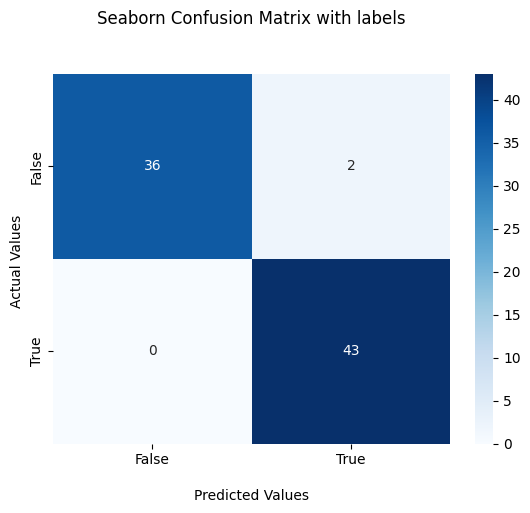

In [23]:
y_preds = np.argmax(sequence_model.predict([X_test_features, X_test_masks]), axis=1)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_preds)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
ax.figure.savefig("cnn_rnn_cf.png")


# Comparative results on test set

In [24]:
df = pd.DataFrame([vivit_scores, cnn_rnn_scores])
df.columns= ['Accuracy', 'Recall', 'Precision', 'F1']
df.index = ['ViViT', 'CNN-RNN']

df.head()

,Accuracy,Recall,Precision,F1
ViViT,1.000000,0.904762,0.511905,0.619955
CNN-RNN,0.975309,1.000000,0.530637,0.691901


### Plot confusion matrices side by side

[1.0, 0.9047619104385376, 0.511904776096344, 0.6199545860290527]
[0.9753086566925049, 1.0, 0.530637264251709, 0.6919011473655701]


Text(0.5, 1.0, 'CNN-RNN CLASSIFIER')

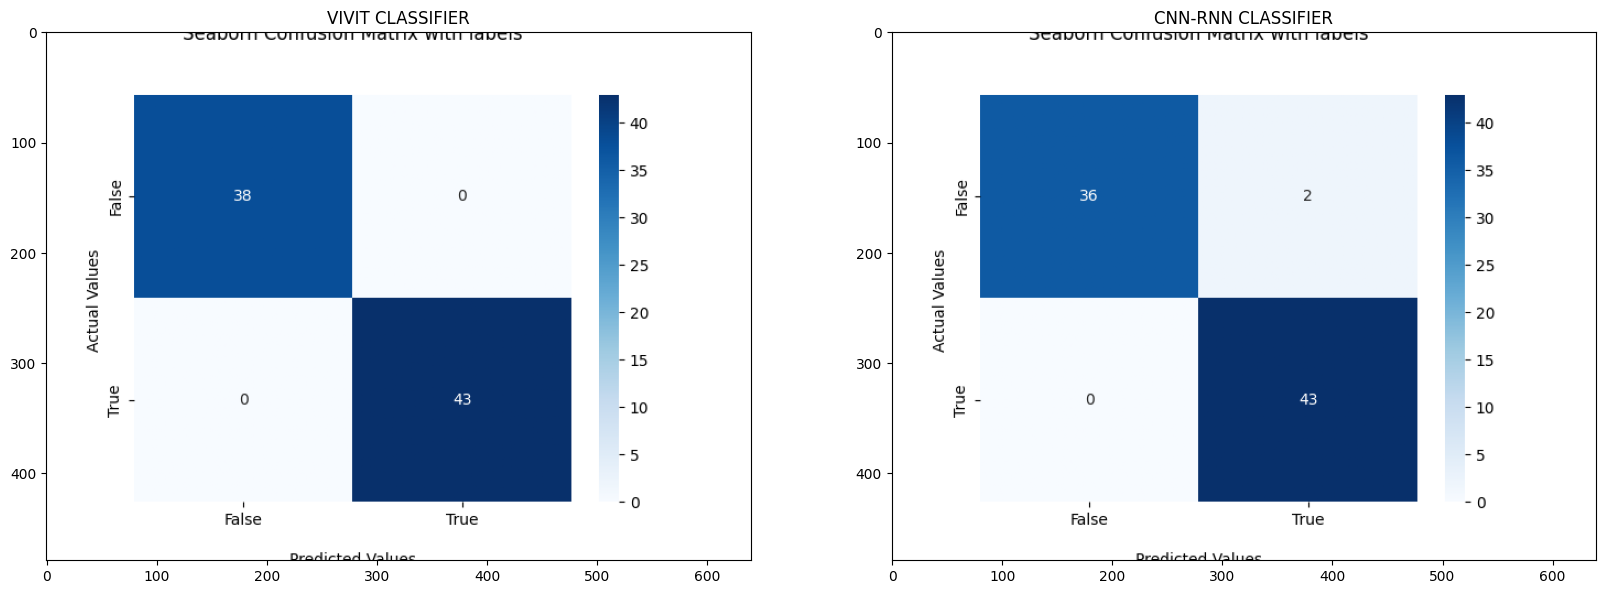

In [25]:
print(vivit_scores)
print(cnn_rnn_scores)

im1 = plt.imread('vivit_cf.png')
im2 = plt.imread('cnn_rnn_cf.png')

f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].imshow(im1)
axarr[0].set_title('VIVIT CLASSIFIER')
axarr[1].imshow(im2)
axarr[1].set_title('CNN-RNN CLASSIFIER')